NOTE: networkx是可视化模块，可以省略

In [1]:
import re
import pandas as pd
import bs4
import requests

import spacy
from spacy import displacy
from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
'''en_core_web_sm: SpaCy工具内嵌的NLP pipeline, 包含tokenizer, tagger, dependency parser, NER model等等
   return: 实例化的pipeline
'''
nlp = spacy.load('en_core_web_sm')
pd.set_option('display.max_colwidth', 200)

In [3]:
candidate_sentences = pd.read_csv("data/test_data.csv")
print(candidate_sentences.head())

(636, 1)
                                                                                                                                                                                                  sentence
0                     china has reported no new locally transmitted coronavirus cases for the first time since the pandemic began, marking a major turning point in the global battle to contain covid-19.
1  at a news conference on thursday morning, officials from china's national health commission announced there had been just 34 new cases in the past 24 hours -- all imported from overseas -- and eig...
2                                                                                                                                     there were there no new reported cases in hubei at all on wednesday.
3  the milestone will likely be held up as proof of the ongoing success of china's sweeping, top-down efforts to control the virus, despite persistent allegations that local offic

In [15]:
doc = nlp("china has reported no new locally transmitted coronavirus cases for the first time since the pandemic began, marking a major turning point in the global battle to contain covid-19.")

for tok in doc:
    print(tok.text, "...", tok.dep_)

china ... nsubj
has ... aux
reported ... ROOT
no ... det
new ... amod
locally ... advmod
transmitted ... amod
coronavirus ... compound
cases ... dobj
for ... prep
the ... det
first ... amod
time ... pobj
since ... mark
the ... det
pandemic ... nsubj
began ... advcl
, ... punct
marking ... advcl
a ... det
major ... amod
turning ... compound
point ... dobj
in ... prep
the ... det
global ... amod
battle ... pobj
to ... aux
contain ... xcomp
covid-19 ... dobj
. ... punct


In [16]:
def get_entities(sent):
    ent1 = ""
    ent2 = ""
    prv_tok_dep = "" 
    prv_tok_text = ""
    prefix = ""
    modifier = ""

    for tok in nlp(sent):
        if tok.dep_ != "punct":
            if tok.dep_ == "compound":
                prefix = tok.text
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " "+ tok.text
            
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " "+ tok.text
            
            if tok.dep_.find("subj") == True:
                ent1 = modifier +" "+ prefix + " "+ tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""      

            if tok.dep_.find("obj") == True:
                ent2 = modifier +" "+ prefix +" "+ tok.text
            
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
    
    return [ent1.strip(), ent2.strip()]


print(get_entities("china has reported no new locally transmitted coronavirus cases for the first time since the pandemic began, marking a major turning point in the global battle to contain covid-19."))

['first coronavirus pandemic', 'global turning covid-19']


In [6]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
    entity_pairs.append(get_entities(i))

entity_pairs[10:20]

100%|██████████| 636/636 [00:04<00:00, 158.08it/s]


[['that', ''],
 ['', 'full  lockdowns'],
 ['increasingly  beijing', 'heavily  pandemic'],
 ['it', 'chinese face government'],
 ['also  which', '3,000  virus'],
 ['chinese  government', 'further quarantine outbreaks'],
 ['thursday state passengers', 'designated  facilities'],
 ['beijing residents', 'own  homes'],
 ['few  us', 'second  infections'],
 ['government', '14 day home quarantine']]

In [18]:
def get_relation(sent):
    doc = nlp(sent)
    matcher = Matcher(nlp.vocab)
 
    pattern = [{'DEP':'ROOT'}, {'DEP':'prep','OP':"?"}, {'DEP':'agent','OP':"?"}, {'POS':'ADJ','OP':"?"}] 
    matcher.add("matching_1", [pattern])

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)

print(get_relation("John completed the task"))

relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

print(pd.Series(relations).value_counts()[:50])

  3%|▎         | 17/636 [00:00<00:03, 168.26it/s]

completed


100%|██████████| 636/636 [00:03<00:00, 175.31it/s]

said          94
is            18
are           17
reported      16
said in       15
told          13
added         12
's            11
was            7
announced      7
says           7
allowed        7
has            5
have           5
been           5
said at        4
warned         4
had            3
reporting      3
be able        3
say            3
be subject     3
continues      3
wrote          3
expected       3
urged          3
published      3
read           3
take           3
recorded       3
become         3
died from      3
thought        2
wrote in       2
include        2
begun          2
showed         2
started        2
moved          2
said on        2
reducing       2
treated in     2
claims         2
threatened     2
need           2
banned         2
noted          2
confirmed      2
comes          2
required       2
dtype: int64


In [19]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

''' visualization '''
G = nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())


In [23]:
kg_df[kg_df['edge']=="announced"]

,source,target,edge
1,where health virus,all health hubei,announced
13,it,chinese face government,announced
142,consecutive coronavirus country,fully coronavirus emergency,announced
361,minister ong ye kung,plan,announced
444,xiangyang city,public railway january,announced
555,british they,mainland china,announced
573,foreign who,14 days,announced


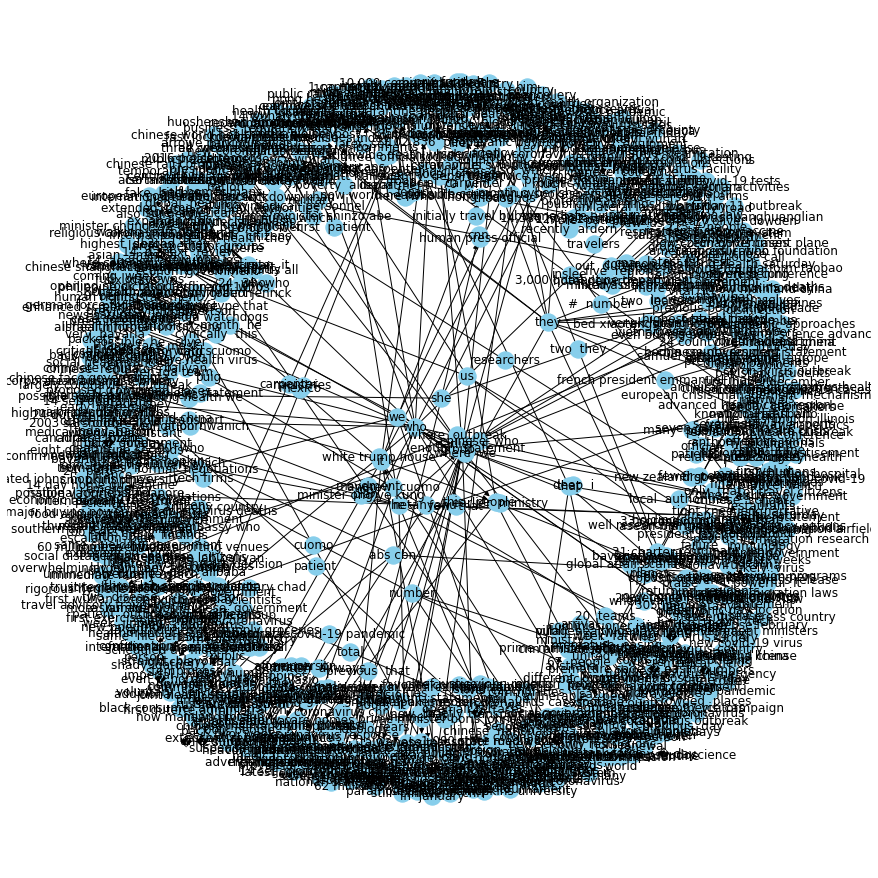

In [11]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

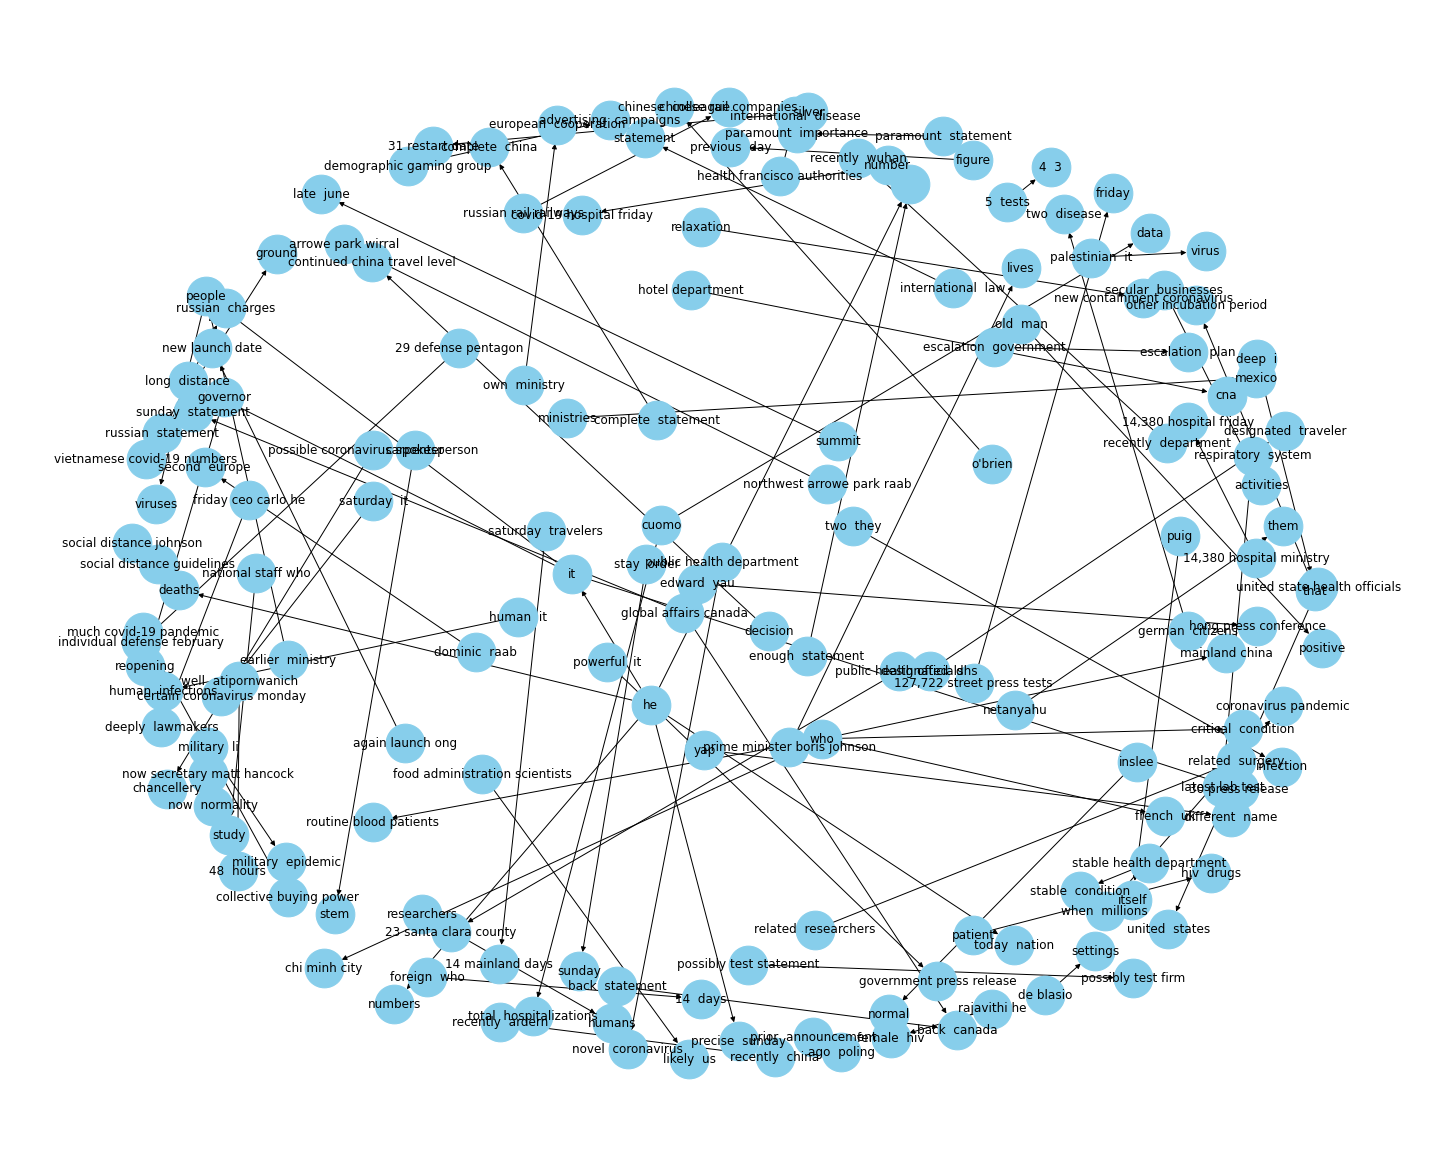

In [31]:
''' composed by '''
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="said"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(20, 16))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

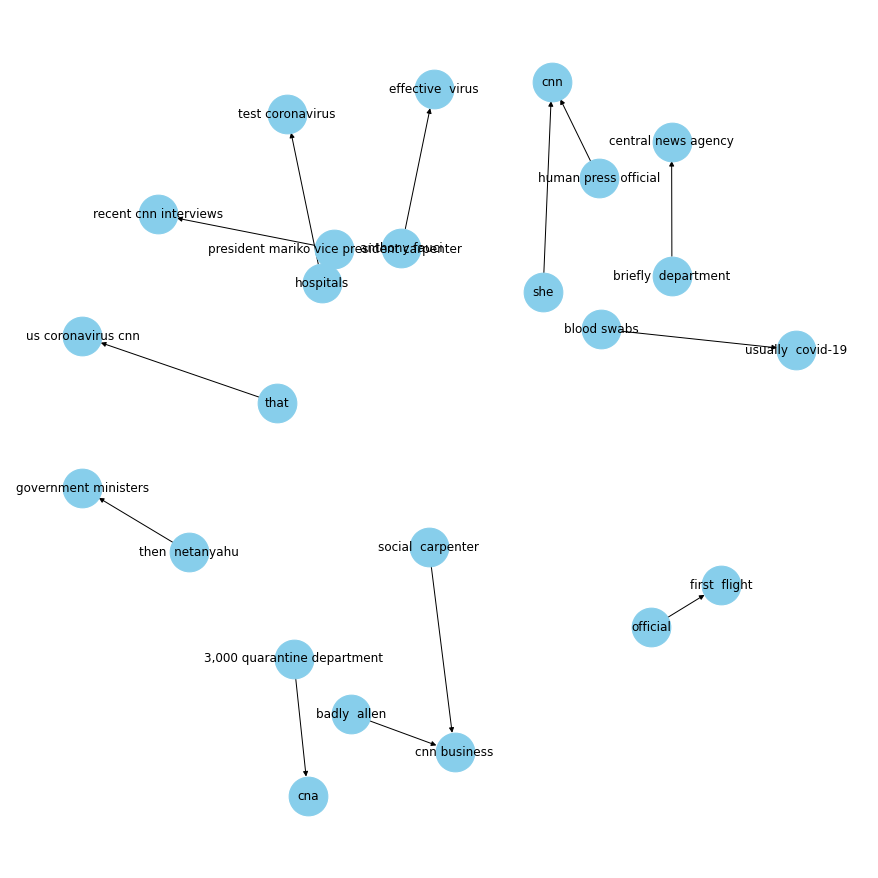

In [13]:
''' written by '''
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="told"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

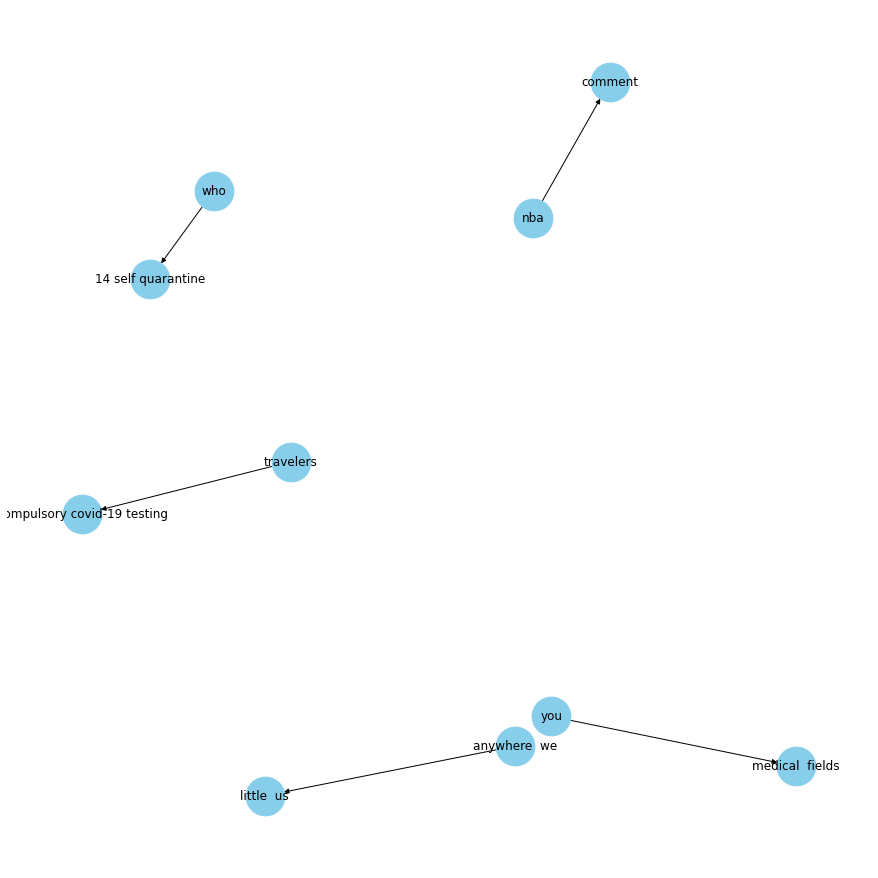

In [14]:
''' released in '''
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="have"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()